In [1]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

This model uses a neural network and GridSearchCV to predict share price impacts of Interest changes

# Read the CSV and Perform Basic Data Cleaning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
df_stock1 = pd.read_csv("../../static/data/wds.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
8854,25/07/2022,30.660000,30.90,30.50,30.719999,30.719999,4997664.0,1.35,1.75,125.0
8855,26/07/2022,30.930000,31.67,30.91,31.570000,31.570000,3831517.0,1.35,1.75,125.0
8856,27/07/2022,31.620001,31.92,31.33,31.500000,31.500000,3033186.0,2.50,1.75,125.0
8857,28/07/2022,32.000000,32.00,31.65,31.969999,31.969999,6012401.0,2.50,1.75,125.0
8858,29/07/2022,32.119999,32.48,31.98,31.980000,31.980000,5024961.0,2.50,1.75,125.0


In [4]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

df_mongo = pd.DataFrame(list(db.wds.find()))
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
# print(last_val)
print(last_date,last_close)
df_mongo.tail


02/08/2022 32.59000015258789


<bound method NDFrame.tail of                            _id        Date       Open       High        Low  \
0     62e99fdf177e6e36996bbe30   1/02/1988   1.272247   1.272247   1.272247   
1     62e99fdf177e6e36996bbe31   2/02/1988   1.272247   1.272247   1.272247   
2     62e99fdf177e6e36996bbe32   3/02/1988   1.272247   1.272247   1.272247   
3     62e99fdf177e6e36996bbe33   4/02/1988   1.272247   1.272247   1.272247   
4     62e99fdf177e6e36996bbe34   5/02/1988   1.272247   1.272247   1.272247   
...                        ...         ...        ...        ...        ...   
8689  62e99fdf177e6e36996be021  27/07/2022  31.620001  31.920000  31.330000   
8690  62e99fdf177e6e36996be022  28/07/2022  32.000000  32.000000  31.650000   
8691  62e99fe1177e6e36996be024  29/07/2022  32.119999  32.480000  31.980000   
8692  62e99fe1177e6e36996be025  01/08/2022  32.169998  32.900002  31.990000   
8693  62e99fe1177e6e36996be026  02/08/2022  32.439999  32.709999  32.330002   

          Close  Adj 

# Use `RBA`,`FED` and `CPI` for the X values

In [5]:
X = df_mongo[["RBA","FED","CPI"]]
y = df_mongo["Close"].values.reshape(-1, 1)
print(X.shape, y.shape)

(8694, 3) (8694, 1)


In [6]:
# X = df_mongo[["RBA","FED","CPI"]]
# y = df_mongo["Close"].values.reshape(-1, 1)
# print(X.shape, y.shape)

In [7]:
y

array([[ 1.272247  ],
       [ 1.272247  ],
       [ 1.272247  ],
       ...,
       [31.97999954],
       [32.84000015],
       [32.59000015]])

# Create a Train Test Split

In [8]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train.info)

(6520, 3) (6520, 1)
(2174, 3) (2174, 1)
<bound method DataFrame.info of         RBA   FED    CPI
1256   5.75  3.00   60.6
1554   4.75  3.75   61.9
6869   2.00  0.25  107.5
6730   2.50  0.25  106.6
5932   4.75  0.25   99.8
...     ...   ...    ...
2895   5.00  5.50   68.7
7813   1.50  2.50  114.1
905    9.50  5.25   59.3
5192   7.00  2.00   92.7
235   17.50  9.97   51.7

[6520 rows x 3 columns]>


In [9]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fit the model

In [10]:
# Fit the model to the training data and calculate the scores for the training and testing data

### BEGIN SOLUTION
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.6341061219977775
Testing Score: 0.6252692814359173


In [11]:
# X_train = X_train.reshape((X_train.shape[0], 1))

In [12]:
#Linear Regression Residual showing difference actual vs predicted
# residual = pd.DataFrame([model.predict(X_train),y_train,(model.predict(X_train)-y_train)])
# residual.tail

Text(0.5, 1.0, 'Residual Plot')

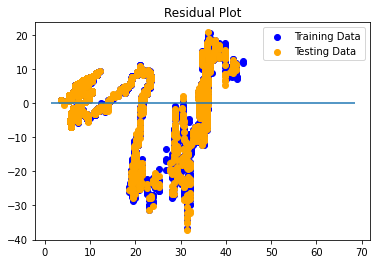

In [13]:
# Plot the Residuals for the Training and Testing data
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

In [14]:
# Linear Regression: X_test predictions to variable
predictions = model.predict(X_test)

#### R2 Score is a very popular metric used for evaluating the performance of linear regression models. Where R2 Score is between 0 and 1, the closer to 1, the better the regression fit.
#### Use MSE or MAE when comparing two or more models, the lower the value of MSE or MAE, the better. MSE (Mean Square Error): Uses Euclidean distance to calculate the error. MSE gives the magnitude of the error only.

In [15]:
# Used X_test, y_test, and model.predict(X_test) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 86.23871613351828, R2: 0.6252692814359173


#### Lasso regression imposes a constraint on the model parameters that causes regression coefficients for some variables to shrink toward zero. It comes with a parameter, alpha , and the higher the alpha , the more feature coefficients are zero. When alpha is 0 , Lasso regression produces the same coefficients as a linear regression.

In [16]:
# LASSO model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train, y_train)

predictions = lasso.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = lasso.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 86.2387481626255, R2: 0.6252691422607197


In [17]:
# Ridge model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train, y_train)

predictions = ridge.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 86.23871595486067, R2: 0.6252692822122333


In [18]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train, y_train)

predictions = elasticnet.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = elasticnet.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 86.23834568264675, R2: 0.6252708911458886


# Hyperparameter Tuning

In [19]:
y_target = df_mongo["Close"]
y_target.shape

(8694,)

In [20]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_target, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6520, 3) (6520,)
(2174, 3) (2174,)


In [21]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(6520, 3) (6520,)
(2174, 3) (2174,)


#### GridSearchCV and RandomizedSearchCV are techniques to evaluate models for a given hyperparameter vector using cross-validation, hence the “CV” suffix of the class name.
#### We are executing many models together is to find which machine learning model works best for this particular dataset.

In [22]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [23]:
regressors = [
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

In [24]:
from time import time
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

RandomForestRegressor()
	Training time: 0.247s
	Prediction time: 0.020s
	Explained variance: 0.9923284069708754
	Mean absolute error: 0.75700846708933
	R2 score: 0.9923096853104179

DecisionTreeRegressor()
	Training time: 0.003s
	Prediction time: 0.001s
	Explained variance: 0.992320133101756
	Mean absolute error: 0.7575222423158536
	R2 score: 0.9923015548125165

KNeighborsRegressor()
	Training time: 0.006s
	Prediction time: 0.006s
	Explained variance: 0.9917279401456578
	Mean absolute error: 0.7834009338546458
	R2 score: 0.9917175371368948

GradientBoostingRegressor()
	Training time: 0.124s
	Prediction time: 0.004s
	Explained variance: 0.9881930669110228
	Mean absolute error: 1.0548210976066856
	R2 score: 0.9881906400131658

KNeighborsRegressor()
	Training time: 0.004s
	Prediction time: 0.005s
	Explained variance: 0.9917279401456578
	Mean absolute error: 0.7834009338546458
	R2 score: 0.9917175371368948

ExtraTreesRegressor()
	Training time: 0.166s
	Prediction time: 0.020s
	Explained va

#### By comparing these results, we can quickly see that RandomForestRegressor and DecisionTreeRegressor are the best models for our data
#### Machine learning models have parameters, which are the internal coefficients set by training or optimizing the model on a training dataset.
#### Parameters are different from hyperparameters. Parameters are learned automatically; hyperparameters are set manually to help guide the learning process.

In [25]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [26]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [28]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [29]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.7590 degrees.
Accuracy = 96.82%.
Model Performance
Average Error: 0.7582 degrees.
Accuracy = 96.82%.
Improvement of 0.00%.


In [30]:
base_accuracy

96.81853639267638

In [31]:
# Hyperparameter tuning has not improved accuracy significantly

In [32]:
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train, y_train)
y_test_pred = model_rfr.predict(X_test)
y_test_pred

array([ 3.00450438,  1.85872034, 34.06300923, ...,  7.82366947,
       44.55147785, 33.31068269])

In [33]:
#RandomForestRegressor Residual showing difference actual vs predicted
residual_dtr = pd.DataFrame([model_rfr.predict(X_train),y_train,(model_rfr.predict(X_train)-y_train)])
residual_dtr.tail

<bound method NDFrame.tail of        0         1          2          3          4         5          6     \
0  3.388890  4.067595  35.069155  38.159019  35.358243  3.388890  34.700571   
1  3.278484  3.826529  34.412247  39.198582  34.461590  3.503573  33.741173   
2  0.110406  0.241066   0.656908  -1.039563   0.896653 -0.114683   0.959398   

        7          8          9     ...       6510      6511       6512  \
0  26.447342  23.050116  35.712829  ...  12.970224  33.84605  19.318444   
1  27.099522  22.770000  35.669998  ...  13.113936  33.77000  20.982298   
2  -0.652180   0.280116   0.042831  ...  -0.143712   0.07605  -1.663854   

       6513       6514       6515       6516          6517       6518  \
0  1.794534  53.530661  10.997939  34.063009  3.268697e+00  53.334327   
1  1.761573  52.436172  10.846399  34.400002  3.268697e+00  54.608780   
2  0.032961   1.094489   0.151540  -0.336993 -3.108624e-15  -1.274453   

       6519  
0  1.980681  
1  1.849652  
2  0.131029  

[3

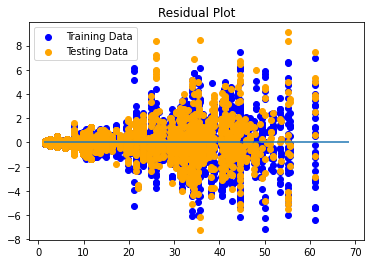

In [34]:
# Make predictions using fitted model
predictions1 = model_rfr.predict(X_test)

# Plotted the difference between the model predicted values and actual y values, versus the model predicted values
plt.scatter(model_rfr.predict(X_train), y_train - model_rfr.predict(X_train), c="blue", label="Training Data")
plt.scatter(model_rfr.predict(X_test), y_test - model_rfr.predict(X_test), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

# Save the Model

In [35]:
import pickle
filename = '../../static/wds_model_rfr.sav'
pickle.dump(model, open(filename, 'wb'))
model_in_rfr = pickle.load(open(filename, 'rb'))

In [36]:
# from joblib import dump,load
# model_in_rfr = load('wds_model_rfr.sav')

In [37]:
rba = float(1.35)
fed = float(1.75)
cpi = float(123.90)
input =40
rfr=[]

def randomforest(rba,fed,cpi):
    for i in range(0,input):
      rfr.append([rba,fed,cpi])
      np.round_(rfr,2,out = None) 
      df = pd.DataFrame(rfr, columns = ['RBA','FED',"CPI"])
      df.round(2)
      pred_rf=model_in_rfr.predict(df)
      df['Prediction'] = pred_rf
      df['Prediction'] = df['Prediction'].astype(float).round(2)
      rba+=0.25
      fed+=0.25
      cpi+=0.25
      # print(df)
    my_rforest = df.to_dict(orient='records')
    for dict_value in my_rforest:
      for k, v in dict_value.items():
        dict_value[k] = round(v, 2)
    return my_rforest,df
# print(my_rforest)
my_rf,df = randomforest(rba,fed,cpi)
print(df,my_rf)


      RBA    FED     CPI  Prediction
0    1.35   1.75  123.90       41.16
1    1.60   2.00  124.15       41.22
2    1.85   2.25  124.40       41.28
3    2.10   2.50  124.65       41.33
4    2.35   2.75  124.90       41.39
5    2.60   3.00  125.15       41.44
6    2.85   3.25  125.40       41.50
7    3.10   3.50  125.65       41.56
8    3.35   3.75  125.90       41.61
9    3.60   4.00  126.15       41.67
10   3.85   4.25  126.40       41.73
11   4.10   4.50  126.65       41.78
12   4.35   4.75  126.90       41.84
13   4.60   5.00  127.15       41.89
14   4.85   5.25  127.40       41.95
15   5.10   5.50  127.65       42.01
16   5.35   5.75  127.90       42.06
17   5.60   6.00  128.15       42.12
18   5.85   6.25  128.40       42.18
19   6.10   6.50  128.65       42.23
20   6.35   6.75  128.90       42.29
21   6.60   7.00  129.15       42.34
22   6.85   7.25  129.40       42.40
23   7.10   7.50  129.65       42.46
24   7.35   7.75  129.90       42.51
25   7.60   8.00  130.15       42.57
2

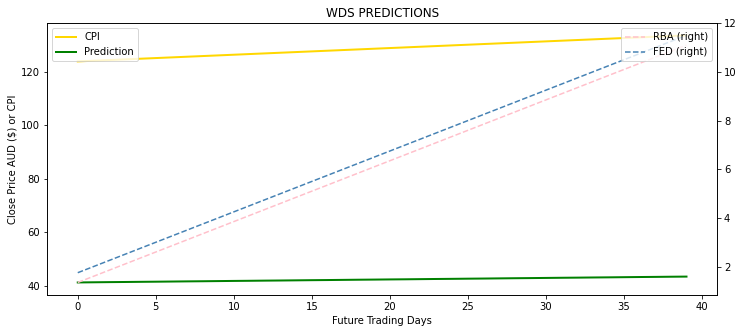

In [38]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
input=40
# df_pred = df.iloc[0:(input-1)]
plot1 = df.plot(y=["CPI","Prediction"], figsize=(12, 5),color=['gold','green'],linewidth=2)
plot2 = df.plot(y=["RBA","FED"],secondary_y=True, ax=plot1,color=['pink','steelblue'],linestyle='dashed')
plt.title('WDS PREDICTIONS')
plot1.set_xlabel('Future Trading Days', fontsize=10)
plot1.set_ylabel('Close Price AUD ($) or CPI', fontsize=10)
plot1.legend(loc='upper left')
plot2.legend(loc='upper right')
plt.savefig('../../static/data/images/wds_rfr_pred.png', bbox_inches="tight")
plt.show()

In [39]:
rba = float(1.35)
fed = float(1.75)
cpi = float(123.90)
def rforest(rba,fed,cpi):
    dtr =[[rba,fed,cpi]]
    df = pd.DataFrame (dtr, columns = ['RBA','FED',"CPI"])
    pred_dtr=model_in_rfr.predict(df)
    df['Prediction'] = pred_dtr
    print(df)
    df_dict = df.to_dict(orient='records')
    return pred_dtr
Pred_rf = rforest(rba,fed,cpi)
print(Pred_rf)

    RBA   FED    CPI  Prediction
0  1.35  1.75  123.9   41.163787
[41.16378732]


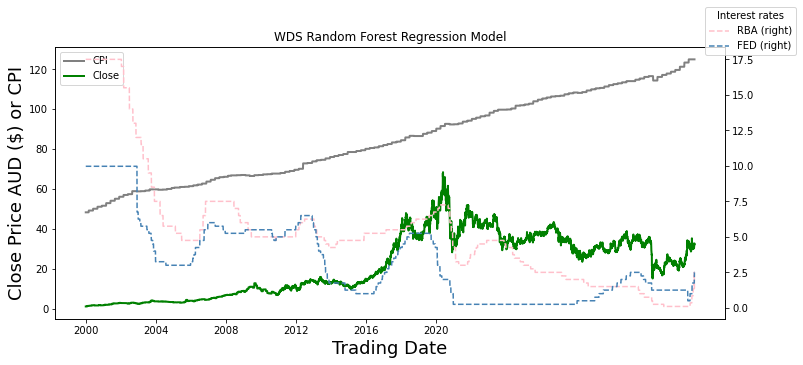

In [40]:
x = np.arange(2000,2024,4)
ax = df_mongo.plot(y=["CPI","Close"], figsize=(12, 5),color=['grey','green'],linewidth=2)
df_mongo.plot(y=["RBA","FED"],secondary_y=True, ax=ax,color=['pink','steelblue'],linestyle='dashed')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=-4, title="Interest rates")
ax.legend(loc='upper left')
ax.set_xticks([0,1000,2000,3000,4000,5000])
ax.set_xticklabels(x, rotation=0)
ax.set_title('WDS Random Forest Regression Model')
ax.set_xlabel('Trading Date', fontsize=18)
ax.set_ylabel('Close Price AUD ($) or CPI', fontsize=18)
plt.savefig('../../static/data/images/wds_tree.png')

#Save predicted error to MongoDB

In [41]:
# Module used to connect Python with MongoDb
import pymongo

In [42]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# Define the 'sharesDB' database in Mongo
db = client.sharesDB.companys

name = 'WDS'

In [43]:
# query the classroom collection
companys = db.find({
      'model': 'RFR',
      'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62e4b499ae01b19986bd7786'), 'model': 'RFR', 'name': 'WDS', 'date': '29/07/2022', 'predicted': 41, 'actual': 31, 'differece': 10.379854935366822, 'accuracy': 96.85}


In [44]:
#save last price actual to variable
actual_price = df_mongo.iloc[-1,5]
actual_date = df_mongo.iloc[-1,1] 
actual_price = int(actual_price)
base_accuracy=round(base_accuracy,2)
print(base_accuracy,actual_price,actual_date)


96.82 32 02/08/2022


In [45]:
# Set keys and values of company
predicted = int(Pred_rf)
difference = Pred_rf-actual_price
difference=difference[0]
print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference},accuracy {base_accuracy}')

date 02/08/2022,predicted 41,actual 32, difference 9.163787316346536,accuracy 96.82


In [46]:
# Delete a document from a collection
db.delete_one(
    {'model': 'RFR','name': name}
)


In [47]:
# Insert a document into the 'companys' collection
db.insert_one(
    {
      'model': 'RFR',
      'name': name,
      'date': actual_date,
      'predicted': predicted,
      'actual': actual_price,
      'difference': round(difference,4),
      'accuracy': base_accuracy        
    }
)

# query the classroom collection
companys = db.find({
  'model': 'RFR',
  'name': name,})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62e9e2f14118c390308ce8d9'), 'model': 'RFR', 'name': 'WDS', 'date': '02/08/2022', 'predicted': 41, 'actual': 32, 'difference': 9.1638, 'accuracy': 96.82}
